In [1]:
%matplotlib inline

import numpy as np
import scipy.stats as stats

from scipy.special import gammaln
from matplotlib import pyplot as plt

import delfi.generator as dg
import delfi.distribution as dd
from delfi.utils.viz import plot_pdf
import delfi.inference as infer
from delfi.summarystats.Identity import Identity

from snl.util.plot import plot_hist_marginals
from lfimodels.snl_exps.util import  save_results_byname, load_results_byname
from lfimodels.rockpaperscissors.rps_sde import rps_sde

model_id = 'rps'
save_path = 'results/' + model_id



seed = 4200

L = 100  # image rows/columns
duration = 100.0
dt = 1.0

nseeds = 20

use_maf = False

/opt/anaconda3/lib/python3.7/site-packages/theano/gpuarray/dnn.py:184: UserWarning: Your cuDNN version is more recent than Theano. If you encounter problems, try updating Theano or downgrading cuDNN to a version >= v5 and <= v7.
  warnings.warn("Your cuDNN version is more recent than "
Using cuDNN version 7401 on context None
Mapped name None to device cuda: GeForce RTX 2080 (0000:42:00.0)


In [2]:
# simulation setup
setup_opts = {
    'n_bypass': 0,
    'filter_sizes': [3,3,3,3, 2, 2],
    'n_filters':    (8,8,8,16,32,32),
    'pool_sizes':   [1,3,2,2, 2, 1],
    'n_hiddens': [50, 50],
    'reg_lambda': 0.01,
    'pilot_samples': 0,  # values are already between 0 and 1
    'verbose': True,
    'prior_norm': False,  # turn off till we've fixed the active trainer. good for uniform priors etc.
    'init_norm': False,
    'input_shape': (3,L,L),
    'verbose': True,
}
if use_maf:
    setup_opts.update(dict(density='maf', maf_mode='random', n_mades=5, maf_actfun='tanh', batch_norm=False))
else:
    setup_opts.update(dict(density='mog', n_components=1))                 

run_opts = {
    'n_train': 1000,
    'n_rounds': 10,
    'minibatch': 100,
    'epochs': 2000,
    'moo': 'resample',
    'proposal': 'discrete',
    'n_null': None,
    'train_on_all': True,
    'max_norm': 0.1,
    'val_frac': 0.1,
    'silent_fail': False,
}

In [3]:
# define a function for showing simulation results as images
def showsim(s_rgb, **kwargs):
    if 'interpolation' not in kwargs.keys():
        kwargs['interpolation'] = 'None'
    s_ryb = s_rgb.copy().reshape(3, L, L)
    s_ryb[0] = np.minimum(1.0, s_ryb[0] + s_ryb[1])
    imobj = plt.imshow(np.moveaxis(s_ryb, 0, -1), **kwargs)
    plt.gca().axis('off')
    return imobj

In [4]:
def init_all(seed, pars_true=None, infobj=infer.SNPEC, svi=False):
    p = dd.Uniform(lower=np.array([-1, -1, -6], dtype=float), 
                   upper=np.array([1, 1, -5], dtype=float), seed=seed)
    n_cores = 8    
    mlist = [rps_sde(dt=dt, duration=duration, L=L, seed=seed + 100 + i) for i in range(n_cores)]
    g = dg.MPGenerator(models=mlist, prior=p, summary=Identity(seed=seed+2), seed=seed+3)
    
    #m = rps_sde(dt=dt, duration=duration, L=L, seed=seed+1)
    #g = dg.Default(model=m, prior=p, summary=Identity(seed=seed+2), seed=seed+3)
    
    if pars_true is None:
        pars_true = g.prior.gen(1).reshape(-1)
    #obs = g.model.gen_single(pars_true)
    obs = g.models[0].gen_single(pars_true)
    obs_stats = g.summary.calc([obs])
    
    if setup_opts['density'] == 'mog':
        setup_opts['svi'] = svi
    
    inf = infobj(generator=g, obs=obs_stats, seed=seed+4, **setup_opts)
    
    return g, pars_true, obs, obs_stats, inf

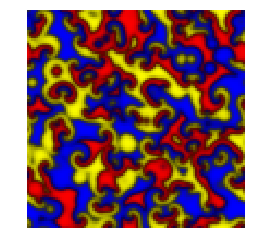

In [5]:
pars_true = np.array([-0.5, 0.5, -5.25])

g, pars_true, obs, obs_stats, inf = init_all(seed, pars_true=pars_true)

showsim(obs_stats)

In [6]:
# print the network structure. "None" indicates the batch dimension
for s in inf.network.layer:
    if s.startswith('mixture'):
        continue
    print('{0}: {1}'.format(s, inf.network.layer[s].output_shape))

input: (None, 30000)
missing: (None, 30000)
reshape: (None, 3, 100, 100)
conv_1: (None, 8, 100, 100)
conv_2: (None, 8, 98, 98)
pool_2: (None, 8, 32, 32)
conv_3: (None, 8, 30, 30)
pool_3: (None, 8, 15, 15)
conv_4: (None, 16, 13, 13)
pool_4: (None, 16, 6, 6)
conv_5: (None, 32, 5, 5)
pool_5: (None, 32, 2, 2)
conv_6: (None, 32, 1, 1)
flatten: (None, 32)
hidden_1: (None, 50)
hidden_2: (None, 50)


In [7]:
log, trn_data, posteriors = inf.run(**run_opts)

Process Worker-14:
Process Worker-9:
Process Worker-13:
Process Worker-16:
Process Worker-15:
Process Worker-12:
Process Worker-11:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/opt/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/opt/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/opt/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/opt/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/opt/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self

  File "/opt/anaconda3/lib/python3.7/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)
KeyboardInterrupt
  File "/home/david/code/delfi_int/delfi/simulator/BaseSimulator.py", line 51, in gen
    rep_list.append(self.gen_single(param))
KeyboardInterrupt
  File "/home/david/code/lfi-models/lfimodels/rockpaperscissors/rps_sde.py", line 85, in gen_single
    c += np.sqrt(self.dt) * self.rng.randn(L ** 2) * noise_c


KeyboardInterrupt: 

  File "/opt/anaconda3/lib/python3.7/multiprocessing/connection.py", line 379, in _recv
    chunk = read(handle, remaining)
KeyboardInterrupt
KeyboardInterrupt
  File "/home/david/code/lfi-models/lfimodels/rockpaperscissors/rps_sde.py", line 81, in gen_single
    noise_b = np.sqrt(mu * b * (1 - rho) + sigma * b * a) / L
  File "/home/david/code/delfi_int/delfi/simulator/BaseSimulator.py", line 51, in gen
    rep_list.append(self.gen_single(param))
  File "/home/david/code/delfi_int/delfi/generator/MPGenerator.py", line 40, in run
    result = self.model.gen(params_batch, pbar=self)
  File "/opt/anaconda3/lib/python3.7/multiprocessing/connection.py", line 250, in recv
    buf = self._recv_bytes()
KeyboardInterrupt
  File "/opt/anaconda3/lib/python3.7/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)
  File "/home/david/code/lfi-models/lfimodels/rockpaperscissors/rps_sde.py", line 96, in gen_single
    a, b, c = a / normfac, b / normfac, c / normfac
  File 

In [ ]:
fig_conv = plt.figure(figsize=(8, 8))
for r in range(run_opts['n_rounds']):
    plt.subplot(run_opts['n_rounds'], 1, r + 1)
    plt.plot(log[r]['loss'],'b',label='training loss')
    plt.plot(log[r]['val_loss_iter'], log[r]['val_loss'], 'm', label='validation loss')
    plt.legend()

In [ ]:
plot_hist_marginals(posteriors[-1].gen(1000), lims=np.vstack((g.prior.lower, g.prior.upper)).T, 
                            gt=pars_true.flatten(), rasterized=False)

In [ ]:
labels_params = ['$\log_{10}(\mu)$', '$\log_{10}(\sigma)$', '$\log_{10}(D)$'] 
# all pairwise marginals of fitted posterior
fig_posterior, _ = plot_pdf(posteriors[-1], lims=[[-1, 1], [-1, 1], [-7, -5]], gt=pars_true.reshape(-1), figsize=(8, 8), resolution=100,
                  labels_params=labels_params, ticks=True)

In [ ]:
fig_nlogptrue = plt.figure()

nsim = (np.arange(run_opts['n_rounds']) + 1.0) * run_opts['n_train']

plt.semilogx(nsim, [-pp.eval(pars_true.reshape(1, -1), log=True) for pp in posteriors],'.-')
plt.ylabel('-log p(true parameters)')
plt.xlabel('Number of simulations (log scale)')

In [ ]:
# draw samples from the prior and posterior
n_samples = 5

g.proposal = None
x_prior = g.gen(n_samples)[1]
x_posterior = np.stack([y[0]['data'] for y in g.model.gen(posteriors[-1].gen(n_samples))], axis=0)

In [ ]:
fig_samples = plt.figure(figsize=(8, 8))
plt.subplot(3, n_samples, 1)
showsim(obs_stats)
plt.title('Observed data')
for i in range(n_samples):
    plt.subplot(3, n_samples, n_samples + i + 1)
    showsim(x_posterior[i])
    if i == 0:
        plt.title('Posterior samples')
    plt.subplot(3, n_samples, 2 * n_samples + i + 1)
    showsim(x_prior[i])
    if i == 0:
        plt.title('Prior samples')

In [ ]:
fig_posterior.savefig('rps_posterior.pdf')
fig_samples.savefig('rps_samples.pdf')
fig_nlogptrue.savefig('rps_nlogptrue.pdf')

!pdftk rps_posterior.pdf rps_samples.pdf rps_nlogptrue.pdf cat output rps.pdf
!rm rps_posterior.pdf
!rm rps_samples.pdf
!rm rps_nlogptrue.pdf

In [8]:
seeds = seed + np.arange(nseeds) * 20

In [9]:
# run multiple seeds with SNPEC discrete MDN
for s in seeds:
    _, pt, o, os, nextinf = init_all(s)  # samples observed data from the marginal (i.e. with parameters from the prior)
    ll, _, pp = nextinf.run(**run_opts)
    
    exp_id = 'rps_' + setup_opts['density'] + '_' + str(s)
    save_results_byname(logs=ll, posteriors=pp, raw_data=o, pars_true=pt, seed=s,
                        setup_opts=setup_opts, run_opts=run_opts, exp_id=exp_id, path=save_path)

In [11]:
run_opts_SNPEAB = {
    'n_train': 1000,
    'n_rounds': 10,
    'minibatch': 100,
    'epochs': 2000,
    'max_norm': 0.1,
    'val_frac': 0.1,
}

In [12]:
# run multiple seeds with SNPEA MDN
for s in seeds:
    
    _, pt, o, os, nextinf = init_all(s, infobj=infer.CDELFI)  # samples observed data from the marginal (i.e. with parameters from the prior)
    ll, _, pp = nextinf.run(**run_opts_SNPEAB)
    
    exp_id = 'rps_' + setup_opts['density'] + '_' + str(s) + '_A'
    save_results_byname(logs=ll, posteriors=pp, raw_data=o, pars_true=pt, seed=s,
                        setup_opts=setup_opts, run_opts=run_opts, exp_id=exp_id, path=save_path)

round :  1
proposal:  None


Stopping at epoch = 203, training loss = -1.7736631186667744, validation loss = -1.154160598105556


round :  2
proposal:  <delfi.distribution.Gaussian.Gaussian object at 0x7fcdc7d95dd8>


Stopping at epoch = 61, training loss = -3.7213936527434646, validation loss = -3.3876832302275957


round :  3
proposal:  <delfi.distribution.Gaussian.Gaussian object at 0x7fcdd6d55f60>


Stopping at epoch = 42, training loss = -5.056525517291194, validation loss = -4.534938283747798


round :  4
proposal:  <delfi.distribution.Gaussian.Gaussian object at 0x7fcdd6e3e668>


Stopping at epoch = 66, training loss = -4.876649509257442, validation loss = -4.505126901454097


analytic correction for proposal seemingly failed!
round :  5
proposal:  <delfi.distribution.Gaussian.Gaussian object at 0x7fcdd53275f8>


Stopping at epoch = 52, training loss = -3.579280629939204, validation loss = -4.0950781353179275


round :  6
proposal:  <delfi.distribution.Gaussian.Gaussian object at 0x7fcd515a2b70>


Stopping at epoch = 112, training loss = -6.186570878810053, validation loss = -6.3445191057387635


round :  7
proposal:  <delfi.distribution.Gaussian.Gaussian object at 0x7fcda12064e0>


Stopping at epoch = 38, training loss = -5.681809898203974, validation loss = -6.195440188235406


round :  8
proposal:  <delfi.distribution.Gaussian.Gaussian object at 0x7fcdafb9dc50>


Stopping at epoch = 92, training loss = -6.25797187406457, validation loss = -6.520109606570368


analytic correction for proposal seemingly failed!
round :  9
proposal:  <delfi.distribution.Gaussian.Gaussian object at 0x7fcdd5722dd8>


Stopping at epoch = 46, training loss = -7.523427744692927, validation loss = -7.20547543126977


round :  10
proposal:  <delfi.distribution.Gaussian.Gaussian object at 0x7fcdd685a940>


Stopping at epoch = 93, training loss = -7.100681253260737, validation loss = -6.493239031619196


round :  1
proposal:  None


Stopping at epoch = 221, training loss = -2.005301993674404, validation loss = -1.812695482558376


round :  2
proposal:  <delfi.distribution.Gaussian.Gaussian object at 0x7fcdd47a6d30>


Stopping at epoch = 117, training loss = -4.552487603015071, validation loss = -6.198020768946772


round :  3
proposal:  <delfi.distribution.Gaussian.Gaussian object at 0x7fcd487e9b00>


Stopping at epoch = 36, training loss = -6.086162768191461, validation loss = -6.190749541110162


round :  4
proposal:  <delfi.distribution.Gaussian.Gaussian object at 0x7fcdd5b89c50>


Stopping at epoch = 131, training loss = -8.186276651209955, validation loss = -8.348262930697565


round :  5
proposal:  <delfi.distribution.Gaussian.Gaussian object at 0x7fcdd649ab70>


Stopping at epoch = 121, training loss = -9.524642024821405, validation loss = -9.634575048274165


round :  6
proposal:  <delfi.distribution.Gaussian.Gaussian object at 0x7fcdaf44e1d0>


Stopping at epoch = 72, training loss = -5.382284928149347, validation loss = -7.683794737643366


analytic correction for proposal seemingly failed!
round :  7
proposal:  <delfi.distribution.Gaussian.Gaussian object at 0x7fcdc6a02cf8>


Stopping at epoch = 100, training loss = -9.451019750422601, validation loss = -8.581244455165033


analytic correction for proposal seemingly failed!
round :  8
proposal:  <delfi.distribution.Gaussian.Gaussian object at 0x7fcd8416f978>


Stopping at epoch = 47, training loss = -10.391461988276605, validation loss = -10.120693097895746


round :  9
proposal:  <delfi.distribution.Gaussian.Gaussian object at 0x7fcd511aa198>


Stopping at epoch = 52, training loss = -10.988374896830683, validation loss = -9.940626436061029


analytic correction for proposal seemingly failed!
round :  10
proposal:  <delfi.distribution.Gaussian.Gaussian object at 0x7fcda8ac3d68>


Stopping at epoch = 42, training loss = -10.002092796153192, validation loss = -10.43695510465539


analytic correction for proposal seemingly failed!
round :  1
proposal:  None


Stopping at epoch = 171, training loss = -1.9464416821662252, validation loss = -1.5683590634528464


round :  2
proposal:  <delfi.distribution.Gaussian.Gaussian object at 0x7fcd8502a400>


Stopping at epoch = 32, training loss = -2.082162206954128, validation loss = -1.9515951927367512


analytic correction for proposal seemingly failed!
round :  3
proposal:  <delfi.distribution.Gaussian.Gaussian object at 0x7fcd87e4c6d8>


Stopping at epoch = 135, training loss = -2.106070161646968, validation loss = -3.240439387148982


analytic correction for proposal seemingly failed!
round :  4
proposal:  <delfi.distribution.Gaussian.Gaussian object at 0x7fcdb71a2d30>


Stopping at epoch = 44, training loss = -2.4957782991591753, validation loss = -2.0702550514403644


analytic correction for proposal seemingly failed!
round :  5
proposal:  <delfi.distribution.Gaussian.Gaussian object at 0x7fcda0641c18>


Stopping at epoch = 31, training loss = -3.3656971104804336, validation loss = -2.6343629773322403


analytic correction for proposal seemingly failed!
round :  6
proposal:  <delfi.distribution.Gaussian.Gaussian object at 0x7fcdd5475f60>


Stopping at epoch = 48, training loss = -3.2601174171630203, validation loss = -2.9241038211051285


round :  7
proposal:  <delfi.distribution.Gaussian.Gaussian object at 0x7fcdd5612860>


Stopping at epoch = 77, training loss = -2.731156607455379, validation loss = -3.858740607089168


round :  8
proposal:  <delfi.distribution.Gaussian.Gaussian object at 0x7fcd8428ada0>


Stopping at epoch = 105, training loss = -4.842523155993587, validation loss = -4.71204935151971


round :  9
proposal:  <delfi.distribution.Gaussian.Gaussian object at 0x7fcd84a8b4e0>


Stopping at epoch = 67, training loss = -4.096812563723689, validation loss = -4.581206003016597


round :  10
proposal:  <delfi.distribution.Gaussian.Gaussian object at 0x7fcdd5e49e10>


Stopping at epoch = 76, training loss = -4.6101698358718215, validation loss = -5.117292218989496


round :  1
proposal:  None


Stopping at epoch = 258, training loss = -2.0236863787833514, validation loss = -2.0774233730498617


round :  2
proposal:  <delfi.distribution.Gaussian.Gaussian object at 0x7fcdafe8f978>


Stopping at epoch = 141, training loss = -7.055146761721735, validation loss = -6.726523733920221


round :  3
proposal:  <delfi.distribution.Gaussian.Gaussian object at 0x7fcd48a83320>


Stopping at epoch = 116, training loss = -8.25854581434167, validation loss = -5.4196029670897765


round :  4
proposal:  <delfi.distribution.Gaussian.Gaussian object at 0x7fcdd6579be0>


Stopping at epoch = 111, training loss = -6.421054902857905, validation loss = -8.071131578272944


round :  5
proposal:  <delfi.distribution.Gaussian.Gaussian object at 0x7fcd50c694e0>


Stopping at epoch = 102, training loss = -8.283372426814203, validation loss = -8.426358581370478


round :  6
proposal:  <delfi.distribution.Gaussian.Gaussian object at 0x7fcd842ffba8>


Stopping at epoch = 63, training loss = -8.0547253187362, validation loss = -7.873646164721613


round :  7
proposal:  <delfi.distribution.Gaussian.Gaussian object at 0x7fcd4904c128>


Stopping at epoch = 60, training loss = -8.858548637217645, validation loss = -7.906831832713251


round :  8
proposal:  <delfi.distribution.Gaussian.Gaussian object at 0x7fcdafcc1198>


Stopping at epoch = 50, training loss = -8.714860726184016, validation loss = -8.34858099061883


round :  9
proposal:  <delfi.distribution.Gaussian.Gaussian object at 0x7fcdd6aedb00>


Stopping at epoch = 33, training loss = -9.044947987383967, validation loss = -9.124471326655511


round :  10
proposal:  <delfi.distribution.Gaussian.Gaussian object at 0x7fcda1618048>


Stopping at epoch = 52, training loss = -7.747562619036798, validation loss = -7.622420736140375


round :  1
proposal:  None


Stopping at epoch = 156, training loss = -1.6016500790778463, validation loss = -1.5346288879576986


round :  2
proposal:  <delfi.distribution.Gaussian.Gaussian object at 0x7fcda8a977f0>


Stopping at epoch = 223, training loss = -3.352756000346309, validation loss = -3.230147779769069


analytic correction for proposal seemingly failed!
round :  3
proposal:  <delfi.distribution.Gaussian.Gaussian object at 0x7fcdafd33dd8>


Stopping at epoch = 54, training loss = -3.581668248957759, validation loss = -3.7742243393126786


round :  4
proposal:  <delfi.distribution.Gaussian.Gaussian object at 0x7fcd84f67978>


Stopping at epoch = 83, training loss = -4.427878337687617, validation loss = -4.6222324951354326


round :  5
proposal:  <delfi.distribution.Gaussian.Gaussian object at 0x7fcda886cda0>


Stopping at epoch = 121, training loss = -6.253027258700495, validation loss = -5.502874689883356


round :  6
proposal:  <delfi.distribution.Gaussian.Gaussian object at 0x7fcdd58c92e8>


Stopping at epoch = 125, training loss = -5.11071523267663, validation loss = -5.335485578364496


round :  7
proposal:  <delfi.distribution.Gaussian.Gaussian object at 0x7fcd508b10b8>


Stopping at epoch = 31, training loss = -5.165832792109613, validation loss = -5.962094908541803


round :  8
proposal:  <delfi.distribution.Gaussian.Gaussian object at 0x7fcd50465588>


Stopping at epoch = 34, training loss = -5.5376835783187195, validation loss = -5.382593355960016


round :  9
proposal:  <delfi.distribution.Gaussian.Gaussian object at 0x7fcdd485eac8>


Stopping at epoch = 75, training loss = -6.104714561289911, validation loss = -6.619360929316644


round :  10
proposal:  <delfi.distribution.Gaussian.Gaussian object at 0x7fcd84143400>


Stopping at epoch = 44, training loss = -7.420066920107965, validation loss = -7.407705965823298


round :  1
proposal:  None


Stopping at epoch = 208, training loss = -2.3012448485556902, validation loss = -1.6235772903624837


round :  2
proposal:  <delfi.distribution.Gaussian.Gaussian object at 0x7fcd494772b0>


Stopping at epoch = 108, training loss = -3.0114337666693984, validation loss = -2.4414271958533584


round :  3
proposal:  <delfi.distribution.Gaussian.Gaussian object at 0x7fcd50f92b38>


Stopping at epoch = 55, training loss = -3.9697766407195387, validation loss = -3.8873223455611527


round :  4
proposal:  <delfi.distribution.Gaussian.Gaussian object at 0x7fcdd57fdda0>


Stopping at epoch = 53, training loss = -3.8245518501464186, validation loss = -3.569055362528926


round :  5
proposal:  <delfi.distribution.Gaussian.Gaussian object at 0x7fcda8a40a90>


Stopping at epoch = 138, training loss = -4.596309934443599, validation loss = -4.166774969882137


round :  6
proposal:  <delfi.distribution.Gaussian.Gaussian object at 0x7fcdd72d7b38>


Stopping at epoch = 68, training loss = -4.925718813723689, validation loss = -4.832553869074946


round :  7
proposal:  <delfi.distribution.Gaussian.Gaussian object at 0x7fcdd6994c18>


Stopping at epoch = 107, training loss = -4.802444101161128, validation loss = -4.092395053691035


round :  8
proposal:  <delfi.distribution.Gaussian.Gaussian object at 0x7fcd504cfe10>


Stopping at epoch = 45, training loss = -4.804615245646602, validation loss = -4.2801983316603955


round :  9
proposal:  <delfi.distribution.Gaussian.Gaussian object at 0x7fcdaffef208>


Stopping at epoch = 68, training loss = -5.119684220141535, validation loss = -4.9683361967269235


round :  10
proposal:  <delfi.distribution.Gaussian.Gaussian object at 0x7fcd4896a208>


Stopping at epoch = 40, training loss = -5.23900121290124, validation loss = -5.300954142398004


round :  1
proposal:  None


Stopping at epoch = 223, training loss = -2.2975448640052143, validation loss = -2.058601494616634


round :  2
proposal:  <delfi.distribution.Gaussian.Gaussian object at 0x7fcd5017ff60>


Stopping at epoch = 53, training loss = -2.8446795805159866, validation loss = -1.514517594164974


round :  3
proposal:  <delfi.distribution.Gaussian.Gaussian object at 0x7fcdd65ff828>


Stopping at epoch = 68, training loss = -4.833476577586299, validation loss = -5.050472203082209


analytic correction for proposal seemingly failed!
round :  4
proposal:  <delfi.distribution.Gaussian.Gaussian object at 0x7fcdd70caef0>


Stopping at epoch = 84, training loss = -3.40114226419366, validation loss = -5.0057961471740064


round :  5
proposal:  <delfi.distribution.Gaussian.Gaussian object at 0x7fcdc7bc6ba8>


Stopping at epoch = 86, training loss = -4.068358465022212, validation loss = -3.8146779688063917


round :  6
proposal:  <delfi.distribution.Gaussian.Gaussian object at 0x7fcdd75dc7f0>


Stopping at epoch = 85, training loss = -5.571801701373224, validation loss = -5.593637891596918


round :  7
proposal:  <delfi.distribution.Gaussian.Gaussian object at 0x7fcdaf9b3be0>


Stopping at epoch = 50, training loss = -4.2826175172988235, validation loss = -4.475437780207759


round :  8
proposal:  <delfi.distribution.Gaussian.Gaussian object at 0x7fcdd4a6d588>


Stopping at epoch = 35, training loss = -5.2520876463118835, validation loss = -3.973253770655757


round :  9
proposal:  <delfi.distribution.Gaussian.Gaussian object at 0x7fcd845b7a58>


Stopping at epoch = 45, training loss = -1.201277581042415, validation loss = -2.92206876356042


analytic correction for proposal seemingly failed!
round :  10
proposal:  <delfi.distribution.Gaussian.Gaussian object at 0x7fcd87beba90>


Stopping at epoch = 55, training loss = -4.95117364007867, validation loss = -4.549878955668574


round :  1
proposal:  None


Stopping at epoch = 341, training loss = -2.5204635508719746, validation loss = -1.6955346997443501


round :  2
proposal:  <delfi.distribution.Gaussian.Gaussian object at 0x7fcdd5b6a8d0>


Stopping at epoch = 120, training loss = -3.1841117270652113, validation loss = -3.361291783637172


round :  3
proposal:  <delfi.distribution.Gaussian.Gaussian object at 0x7fcdd68bfb00>


Stopping at epoch = 93, training loss = -3.733570032900935, validation loss = -3.6736813457671462


round :  4
proposal:  <delfi.distribution.Gaussian.Gaussian object at 0x7fcdd6cceb00>


Stopping at epoch = 74, training loss = -1.918680575675136, validation loss = -2.730058213061458


round :  5
proposal:  <delfi.distribution.Gaussian.Gaussian object at 0x7fcdd69eec88>


Stopping at epoch = 122, training loss = -4.057422128504879, validation loss = -3.986599341220027


round :  6
proposal:  <delfi.distribution.Gaussian.Gaussian object at 0x7fcdd57f1be0>


Stopping at epoch = 44, training loss = -3.8222581394378006, validation loss = -3.1957996185485182


round :  7
proposal:  <delfi.distribution.Gaussian.Gaussian object at 0x7fcdd65d39e8>


Stopping at epoch = 53, training loss = -4.388031845873957, validation loss = -4.536255880183345


round :  8
proposal:  <delfi.distribution.Gaussian.Gaussian object at 0x7fcd87c311d0>


Stopping at epoch = 28, training loss = -4.0141545065108595, validation loss = -3.4138987072173417


round :  9
proposal:  <delfi.distribution.Gaussian.Gaussian object at 0x7fcda0af97b8>


Stopping at epoch = 37, training loss = -4.314528075045711, validation loss = -4.098571434802181


round :  10
proposal:  <delfi.distribution.Gaussian.Gaussian object at 0x7fcd489c3320>


Stopping at epoch = 46, training loss = -4.399867826289302, validation loss = -4.137310176676875


round :  1
proposal:  None


Stopping at epoch = 208, training loss = -1.5061298616591756, validation loss = -1.108287623709804


round :  2
proposal:  <delfi.distribution.Gaussian.Gaussian object at 0x7fcda1547b38>


Stopping at epoch = 72, training loss = -4.73936030942834, validation loss = -4.9146146925154985


round :  3
proposal:  <delfi.distribution.Gaussian.Gaussian object at 0x7fcdd6039da0>


Stopping at epoch = 56, training loss = -6.620775223559503, validation loss = -6.759793158358698


round :  4
proposal:  <delfi.distribution.Gaussian.Gaussian object at 0x7fcda0c81f28>


Stopping at epoch = 74, training loss = -7.223469301051264, validation loss = -6.9266100843612


round :  5
proposal:  <delfi.distribution.Gaussian.Gaussian object at 0x7fcdd4503ba8>


Stopping at epoch = 64, training loss = -6.010704456156855, validation loss = -7.255010834521418


round :  6
proposal:  <delfi.distribution.Gaussian.Gaussian object at 0x7fcdaf0742e8>


Stopping at epoch = 65, training loss = -6.8452925403777405, validation loss = -6.957993765658503


round :  7
proposal:  <delfi.distribution.Gaussian.Gaussian object at 0x7fcd50c32a90>


Stopping at epoch = 72, training loss = -7.367694192713861, validation loss = -7.187106400317316


round :  8
proposal:  <delfi.distribution.Gaussian.Gaussian object at 0x7fcdd57f3f60>


Stopping at epoch = 110, training loss = -7.244310279673701, validation loss = -7.189267636126642


round :  9
proposal:  <delfi.distribution.Gaussian.Gaussian object at 0x7fcdaf436240>


Stopping at epoch = 34, training loss = -7.649839292353754, validation loss = -7.764776783770685


analytic correction for proposal seemingly failed!
round :  10
proposal:  <delfi.distribution.Gaussian.Gaussian object at 0x7fcdd7679fd0>


Stopping at epoch = 51, training loss = -7.533528686350946, validation loss = -8.392287374323969


round :  1
proposal:  None


Stopping at epoch = 190, training loss = -2.3495216568175614, validation loss = -1.6501897772017782


round :  2
proposal:  <delfi.distribution.Gaussian.Gaussian object at 0x7fcda1691710>


Stopping at epoch = 213, training loss = -3.3389655955497086, validation loss = -2.268892937487727


round :  3
proposal:  <delfi.distribution.Gaussian.Gaussian object at 0x7fcdd425a630>


Stopping at epoch = 47, training loss = -4.2398936517897905, validation loss = -3.913109184092647


round :  4
proposal:  <delfi.distribution.Gaussian.Gaussian object at 0x7fcd49178a58>


Stopping at epoch = 60, training loss = -4.218327971285945, validation loss = -3.5909248026076614


round :  5
proposal:  <delfi.distribution.Gaussian.Gaussian object at 0x7fcda06ebfd0>


Stopping at epoch = 100, training loss = -4.909580527133113, validation loss = -4.5230102499190625


round :  6
proposal:  <delfi.distribution.Gaussian.Gaussian object at 0x7fcd49e04e10>


Stopping at epoch = 120, training loss = -5.823089762515192, validation loss = -4.723274136370784


round :  7
proposal:  <delfi.distribution.Gaussian.Gaussian object at 0x7fcda11be588>


Stopping at epoch = 45, training loss = -5.905505004710322, validation loss = -5.697956968135004


round :  8
proposal:  <delfi.distribution.Gaussian.Gaussian object at 0x7fcd845b71d0>


Stopping at epoch = 47, training loss = -6.190483618563776, validation loss = -5.4035613830748845


round :  9
proposal:  <delfi.distribution.Gaussian.Gaussian object at 0x7fcd49e2f438>


Stopping at epoch = 90, training loss = -6.385365958994989, validation loss = -5.326411753481989


round :  10
proposal:  <delfi.distribution.Gaussian.Gaussian object at 0x7fcdd5588160>


Stopping at epoch = 82, training loss = -7.793436480349665, validation loss = -6.775008245295648


round :  1
proposal:  None


Stopping at epoch = 256, training loss = -2.47925870496667, validation loss = -2.0404603298369706


round :  2
proposal:  <delfi.distribution.Gaussian.Gaussian object at 0x7fcd87ce0e10>


Stopping at epoch = 67, training loss = -3.4532078202430068, validation loss = -3.0406406815711318


round :  3
proposal:  <delfi.distribution.Gaussian.Gaussian object at 0x7fcdc6396588>


Stopping at epoch = 67, training loss = -3.9001041801635083, validation loss = -3.3088304622832596


round :  4
proposal:  <delfi.distribution.Gaussian.Gaussian object at 0x7fcda08ceb00>


Stopping at epoch = 76, training loss = -3.571063075846797, validation loss = -3.696453986949092


round :  5
proposal:  <delfi.distribution.Gaussian.Gaussian object at 0x7fcdafbf4ba8>


Stopping at epoch = 75, training loss = -4.712443128413326, validation loss = -4.490359612292415


round :  6
proposal:  <delfi.distribution.Gaussian.Gaussian object at 0x7fcd49ad2080>


Stopping at epoch = 62, training loss = -3.8891948803130445, validation loss = -3.8751858671370805


round :  7
proposal:  <delfi.distribution.Gaussian.Gaussian object at 0x7fcdd52436d8>


Stopping at epoch = 86, training loss = -4.421134749240046, validation loss = -3.923710518664485


round :  8
proposal:  <delfi.distribution.Gaussian.Gaussian object at 0x7fcd4969b908>


Stopping at epoch = 43, training loss = -3.7863257511321367, validation loss = -3.878485132044917


round :  9
proposal:  <delfi.distribution.Gaussian.Gaussian object at 0x7fcd50bdb438>


Stopping at epoch = 98, training loss = -4.481669345683223, validation loss = -3.801912709063655


round :  10
proposal:  <delfi.distribution.Gaussian.Gaussian object at 0x7fcd507400b8>


Stopping at epoch = 83, training loss = -4.4225377233687695, validation loss = -3.847720108813411


round :  1
proposal:  None


Stopping at epoch = 260, training loss = -2.0168065555754966, validation loss = -1.5362969048682515


round :  2
proposal:  <delfi.distribution.Gaussian.Gaussian object at 0x7fcda17bea58>


Stopping at epoch = 105, training loss = -2.802909165209895, validation loss = -2.4881272443000135


round :  3
proposal:  <delfi.distribution.Gaussian.Gaussian object at 0x7fcda8999be0>


Stopping at epoch = 65, training loss = -3.3627287252608595, validation loss = -4.170731373614436


round :  4
proposal:  <delfi.distribution.Gaussian.Gaussian object at 0x7fcdafa64b38>


Stopping at epoch = 93, training loss = -4.143982811755305, validation loss = -4.61898318845666


round :  5
proposal:  <delfi.distribution.Gaussian.Gaussian object at 0x7fcdd746cc18>


Stopping at epoch = 74, training loss = -5.096302185839777, validation loss = -5.087679296321039


round :  6
proposal:  <delfi.distribution.Gaussian.Gaussian object at 0x7fcdaf217198>


Stopping at epoch = 34, training loss = -4.302311054057246, validation loss = -3.6730197771254836


analytic correction for proposal seemingly failed!
round :  7
proposal:  <delfi.distribution.Gaussian.Gaussian object at 0x7fcda0187080>


Stopping at epoch = 47, training loss = -4.423041759318477, validation loss = -4.899769130534297


analytic correction for proposal seemingly failed!
round :  8
proposal:  <delfi.distribution.Gaussian.Gaussian object at 0x7fcdc4065080>


Stopping at epoch = 58, training loss = -5.218537870234614, validation loss = -4.816263228243953


round :  9
proposal:  <delfi.distribution.Gaussian.Gaussian object at 0x7fcd84c10a20>


Stopping at epoch = 32, training loss = -4.825763216799861, validation loss = -5.027675796336299


round :  10
proposal:  <delfi.distribution.Gaussian.Gaussian object at 0x7fcd8505bc18>


Stopping at epoch = 90, training loss = -4.049156213587886, validation loss = -3.2759441478911695


round :  1
proposal:  None


Stopping at epoch = 173, training loss = -1.5079833157721823, validation loss = -1.6051049788657492


round :  2
proposal:  <delfi.distribution.Gaussian.Gaussian object at 0x7fcd8407fef0>


Stopping at epoch = 116, training loss = -2.603116994685298, validation loss = -2.6867131932441053


round :  3
proposal:  <delfi.distribution.Gaussian.Gaussian object at 0x7fcda0599358>


Stopping at epoch = 77, training loss = -3.5221517570678054, validation loss = -3.8718649728957475


round :  4
proposal:  <delfi.distribution.Gaussian.Gaussian object at 0x7fcdaf9b3780>


Stopping at epoch = 50, training loss = -3.8679474695388136, validation loss = -3.8585937603179277


round :  5
proposal:  <delfi.distribution.Gaussian.Gaussian object at 0x7fcdd54d7dd8>


Stopping at epoch = 65, training loss = -3.547228542155391, validation loss = -3.5668157108489336


round :  6
proposal:  <delfi.distribution.Gaussian.Gaussian object at 0x7fcd48734dd8>


Stopping at epoch = 46, training loss = -4.248594756907588, validation loss = -4.260772076434261


round :  7
proposal:  <delfi.distribution.Gaussian.Gaussian object at 0x7fcd83ff2b70>


Stopping at epoch = 101, training loss = -4.816731677836543, validation loss = -4.694047571009761


round :  8
proposal:  <delfi.distribution.Gaussian.Gaussian object at 0x7fcdd73ef908>


Stopping at epoch = 42, training loss = -3.919901595896846, validation loss = -4.487301436251766


round :  9
proposal:  <delfi.distribution.Gaussian.Gaussian object at 0x7fcdd55ecfd0>


Stopping at epoch = 41, training loss = -5.0578247888747505, validation loss = -4.91052278119958


analytic correction for proposal seemingly failed!
round :  10
proposal:  <delfi.distribution.Gaussian.Gaussian object at 0x7fcdc52b43c8>


Stopping at epoch = 100, training loss = -4.971124916857844, validation loss = -4.5404398639861405


round :  1
proposal:  None


Stopping at epoch = 251, training loss = -1.8990523632232015, validation loss = -2.0991269286338157


round :  2
proposal:  <delfi.distribution.Gaussian.Gaussian object at 0x7fcd49235668>


Stopping at epoch = 147, training loss = -6.008803497141962, validation loss = -5.925970183200007


round :  3
proposal:  <delfi.distribution.Gaussian.Gaussian object at 0x7fcd8420e748>


Stopping at epoch = 66, training loss = -7.031346998995905, validation loss = -7.184105706996088


analytic correction for proposal seemingly failed!
round :  4
proposal:  <delfi.distribution.Gaussian.Gaussian object at 0x7fcd48ad1d68>


Stopping at epoch = 103, training loss = -7.420864940470819, validation loss = -7.74605956155694


round :  5
proposal:  <delfi.distribution.Gaussian.Gaussian object at 0x7fcd49d1b9b0>


Stopping at epoch = 70, training loss = -8.099463325327998, validation loss = -7.586967230624323


round :  6
proposal:  <delfi.distribution.Gaussian.Gaussian object at 0x7fcdb71ccf98>


Stopping at epoch = 68, training loss = -7.895459342784052, validation loss = -8.415599275416499


round :  7
proposal:  <delfi.distribution.Gaussian.Gaussian object at 0x7fcda1882780>


Stopping at epoch = 124, training loss = -7.156484323329096, validation loss = -6.757310739344721


round :  8
proposal:  <delfi.distribution.Gaussian.Gaussian object at 0x7fcdc7bb3d68>


Stopping at epoch = 46, training loss = -7.313234687632685, validation loss = -7.117815314120417


analytic correction for proposal seemingly failed!
round :  9
proposal:  <delfi.distribution.Gaussian.Gaussian object at 0x7fcdae94cf28>


Stopping at epoch = 61, training loss = -8.311582885569697, validation loss = -3.830290375537044


analytic correction for proposal seemingly failed!
round :  10
proposal:  <delfi.distribution.Gaussian.Gaussian object at 0x7fcddab5cd68>


Stopping at epoch = 73, training loss = -8.772839756793147, validation loss = -8.23362252313531


round :  1
proposal:  None


Stopping at epoch = 193, training loss = -0.8328621776763262, validation loss = -1.1322971351805986


round :  2
proposal:  <delfi.distribution.Gaussian.Gaussian object at 0x7fcda08cebe0>


Stopping at epoch = 58, training loss = -2.2480305035773576, validation loss = -2.003603545016414


round :  3
proposal:  <delfi.distribution.Gaussian.Gaussian object at 0x7fcd50b67240>


Stopping at epoch = 74, training loss = -3.8767830141249955, validation loss = -3.79665230829156


round :  4
proposal:  <delfi.distribution.Gaussian.Gaussian object at 0x7fcda11c1c18>


Stopping at epoch = 53, training loss = -3.323905382937556, validation loss = -4.092014222926265


round :  5
proposal:  <delfi.distribution.Gaussian.Gaussian object at 0x7fcdafbf4ac8>


Stopping at epoch = 100, training loss = -3.3531236227217973, validation loss = -3.471056607550746


round :  6
proposal:  <delfi.distribution.Gaussian.Gaussian object at 0x7fcd48718c88>


Stopping at epoch = 88, training loss = -2.6420220335189164, validation loss = -3.8589228923980055


round :  7
proposal:  <delfi.distribution.Gaussian.Gaussian object at 0x7fcdafd7ab00>


Stopping at epoch = 34, training loss = -3.1679833753768265, validation loss = -4.109553738421565


analytic correction for proposal seemingly failed!
round :  8
proposal:  <delfi.distribution.Gaussian.Gaussian object at 0x7fcdd61e1cf8>


Stopping at epoch = 27, training loss = -4.100772782153254, validation loss = -3.777591424769527


analytic correction for proposal seemingly failed!
round :  9
proposal:  <delfi.distribution.Gaussian.Gaussian object at 0x7fcd8487b860>


Stopping at epoch = 47, training loss = -3.8866432579222976, validation loss = -3.4340442569915113


analytic correction for proposal seemingly failed!
round :  10
proposal:  <delfi.distribution.Gaussian.Gaussian object at 0x7fcd8444c240>


Stopping at epoch = 24, training loss = -4.16471316892541, validation loss = -3.4272625024977983


analytic correction for proposal seemingly failed!
round :  1
proposal:  None


Stopping at epoch = 182, training loss = -2.02344129878915, validation loss = -1.194599936789638


round :  2
proposal:  <delfi.distribution.Gaussian.Gaussian object at 0x7fcd84a49c18>


Stopping at epoch = 210, training loss = -3.480152579135066, validation loss = -3.8249041231337846


round :  3
proposal:  <delfi.distribution.Gaussian.Gaussian object at 0x7fcd849ea9e8>


Stopping at epoch = 83, training loss = -4.966383953875667, validation loss = -4.123293629473811


analytic correction for proposal seemingly failed!
round :  4
proposal:  <delfi.distribution.Gaussian.Gaussian object at 0x7fcda0180828>


Stopping at epoch = 141, training loss = -6.595914078539972, validation loss = -6.800586739367609


round :  5
proposal:  <delfi.distribution.Gaussian.Gaussian object at 0x7fcdd64746d8>


Stopping at epoch = 93, training loss = -4.302571516818172, validation loss = -6.439534469432001


round :  6
proposal:  <delfi.distribution.Gaussian.Gaussian object at 0x7fcd494da908>


Stopping at epoch = 56, training loss = -3.8870486934844313, validation loss = -6.8933835895720765


round :  7
proposal:  <delfi.distribution.Gaussian.Gaussian object at 0x7fcd5158b1d0>


Stopping at epoch = 52, training loss = -6.746375623530512, validation loss = -7.17601896364129


round :  8
proposal:  <delfi.distribution.Gaussian.Gaussian object at 0x7fcd48e91d68>


Stopping at epoch = 53, training loss = -7.627478476351862, validation loss = -6.940086499041681


round :  9
proposal:  <delfi.distribution.Gaussian.Gaussian object at 0x7fcda09317b8>


Stopping at epoch = 98, training loss = -6.4901083572570135, validation loss = -7.728054343051081


round :  10
proposal:  <delfi.distribution.Gaussian.Gaussian object at 0x7fcdaead3128>


Stopping at epoch = 75, training loss = -6.6714121635619446, validation loss = -7.805573950595026


round :  1
proposal:  None


Stopping at epoch = 282, training loss = -2.0647661216918296, validation loss = -1.4624519451323812


round :  2
proposal:  <delfi.distribution.Gaussian.Gaussian object at 0x7fcdd65a39b0>


Stopping at epoch = 126, training loss = -3.5075762994948683, validation loss = -3.337021616286403


analytic correction for proposal seemingly failed!
round :  3
proposal:  <delfi.distribution.Gaussian.Gaussian object at 0x7fcd84725438>


Stopping at epoch = 67, training loss = -3.807083559817439, validation loss = -3.6504958446685136


analytic correction for proposal seemingly failed!
round :  4
proposal:  <delfi.distribution.Gaussian.Gaussian object at 0x7fcd50466a20>


Stopping at epoch = 46, training loss = -3.4555887230101883, validation loss = -3.3564409526053725


round :  5
proposal:  <delfi.distribution.Gaussian.Gaussian object at 0x7fcdd483de10>


Stopping at epoch = 204, training loss = -3.2781977613631543, validation loss = -4.176612654513484


analytic correction for proposal seemingly failed!
round :  6
proposal:  <delfi.distribution.Gaussian.Gaussian object at 0x7fcda190f2e8>


Stopping at epoch = 30, training loss = -6.0532614143554015, validation loss = -4.837295928782587


analytic correction for proposal seemingly failed!
round :  7
proposal:  <delfi.distribution.Gaussian.Gaussian object at 0x7fcdd6109cf8>


Stopping at epoch = 40, training loss = -5.301176272219782, validation loss = -5.174310894793634


round :  8
proposal:  <delfi.distribution.Gaussian.Gaussian object at 0x7fcdaea27a20>


Stopping at epoch = 123, training loss = -5.5769582470122625, validation loss = -4.367875686473018


round :  9
proposal:  <delfi.distribution.Gaussian.Gaussian object at 0x7fcdc6a48b38>


Stopping at epoch = 102, training loss = -5.539545484370356, validation loss = -5.049374848193293


round :  10
proposal:  <delfi.distribution.Gaussian.Gaussian object at 0x7fcd4975afd0>


Stopping at epoch = 35, training loss = -6.257507510966425, validation loss = -5.76594354707635


round :  1
proposal:  None


Stopping at epoch = 238, training loss = -2.408716910666591, validation loss = -1.909181078261501


round :  2
proposal:  <delfi.distribution.Gaussian.Gaussian object at 0x7fcdafc7bf98>


Stopping at epoch = 48, training loss = -3.6703687174979507, validation loss = -3.6658644517127335


analytic correction for proposal seemingly failed!
round :  3
proposal:  <delfi.distribution.Gaussian.Gaussian object at 0x7fcdd4a68080>


Stopping at epoch = 114, training loss = -5.370127025431757, validation loss = -4.772150793856746


round :  4
proposal:  <delfi.distribution.Gaussian.Gaussian object at 0x7fcd83f8a630>


Stopping at epoch = 142, training loss = -3.6192942054930985, validation loss = -2.249808660334712


round :  5
proposal:  <delfi.distribution.Gaussian.Gaussian object at 0x7fcdc63bd7b8>


Stopping at epoch = 100, training loss = -5.728094063586359, validation loss = -4.431374269312983


round :  6
proposal:  <delfi.distribution.Gaussian.Gaussian object at 0x7fcdae3cdcc0>


Stopping at epoch = 67, training loss = -5.780807400530939, validation loss = -6.996630545443659


round :  7
proposal:  <delfi.distribution.Gaussian.Gaussian object at 0x7fcdb43adc18>


Stopping at epoch = 61, training loss = -6.42835357744134, validation loss = -5.979946523493891


analytic correction for proposal seemingly failed!
round :  8
proposal:  <delfi.distribution.Gaussian.Gaussian object at 0x7fcdd75e0550>


Stopping at epoch = 77, training loss = -6.504218812770014, validation loss = -6.649906225985651


analytic correction for proposal seemingly failed!
round :  9
proposal:  <delfi.distribution.Gaussian.Gaussian object at 0x7fcdae248860>


Stopping at epoch = 35, training loss = -6.703126726931696, validation loss = -6.104100604838496


analytic correction for proposal seemingly failed!
round :  10
proposal:  <delfi.distribution.Gaussian.Gaussian object at 0x7fcdaee015f8>


Stopping at epoch = 37, training loss = -6.57188469488061, validation loss = -5.525301447695856


analytic correction for proposal seemingly failed!
round :  1
proposal:  None


Stopping at epoch = 175, training loss = -2.387386661357051, validation loss = -0.6687077434722248


round :  2
proposal:  <delfi.distribution.Gaussian.Gaussian object at 0x7fcd50bfc898>


Stopping at epoch = 155, training loss = -1.5892547925177871, validation loss = -3.0893141444388688


round :  3
proposal:  <delfi.distribution.Gaussian.Gaussian object at 0x7fcd8450a978>


Stopping at epoch = 57, training loss = -3.052240346259242, validation loss = -3.273770323580867


round :  4
proposal:  <delfi.distribution.Gaussian.Gaussian object at 0x7fcdaf9d4358>


Stopping at epoch = 40, training loss = -3.1288131411734876, validation loss = -2.5606824715796765


round :  5
proposal:  <delfi.distribution.Gaussian.Gaussian object at 0x7fcdd4a92898>


Stopping at epoch = 96, training loss = -4.370856943911678, validation loss = -3.7967374809447585


round :  6
proposal:  <delfi.distribution.Gaussian.Gaussian object at 0x7fcdc7e26b70>


Stopping at epoch = 78, training loss = -5.9413264282409, validation loss = -5.586557575053339


round :  7
proposal:  <delfi.distribution.Gaussian.Gaussian object at 0x7fcdae954b00>


Stopping at epoch = 72, training loss = -6.2741661174956604, validation loss = -6.219233995265131


round :  8
proposal:  <delfi.distribution.Gaussian.Gaussian object at 0x7fcd87ebea58>


Stopping at epoch = 114, training loss = -5.503842268771296, validation loss = -5.336721235102777


analytic correction for proposal seemingly failed!
round :  9
proposal:  <delfi.distribution.Gaussian.Gaussian object at 0x7fcd846c4a20>


Stopping at epoch = 62, training loss = -6.33397640783227, validation loss = -6.1609266145888615


round :  10
proposal:  <delfi.distribution.Gaussian.Gaussian object at 0x7fcdd6fe5668>


Stopping at epoch = 77, training loss = -5.127135539836054, validation loss = -4.635468135661251


round :  1
proposal:  None


Stopping at epoch = 283, training loss = -2.1934568460646933, validation loss = -0.7165857155982319


round :  2
proposal:  <delfi.distribution.Gaussian.Gaussian object at 0x7fcda06cdf28>


Stopping at epoch = 221, training loss = -5.89726386625207, validation loss = -4.630241771525508


round :  3
proposal:  <delfi.distribution.Gaussian.Gaussian object at 0x7fcd49054b70>


Stopping at epoch = 78, training loss = -6.7269292123977, validation loss = -6.439965377635126


round :  4
proposal:  <delfi.distribution.Gaussian.Gaussian object at 0x7fcdd6c89a20>


Stopping at epoch = 73, training loss = -6.800385890788203, validation loss = -6.622277694529657


round :  5
proposal:  <delfi.distribution.Gaussian.Gaussian object at 0x7fcda186b828>


Stopping at epoch = 48, training loss = -6.592128949946527, validation loss = -6.005195465869074


round :  6
proposal:  <delfi.distribution.Gaussian.Gaussian object at 0x7fcdd6b0d0f0>


Stopping at epoch = 51, training loss = -7.157647357768183, validation loss = -6.5552508981887145


round :  7
proposal:  <delfi.distribution.Gaussian.Gaussian object at 0x7fcdd47a64e0>


Stopping at epoch = 68, training loss = -6.721632452792291, validation loss = -7.107387343234186


analytic correction for proposal seemingly failed!
round :  8
proposal:  <delfi.distribution.Gaussian.Gaussian object at 0x7fcdaffc1908>


Stopping at epoch = 53, training loss = -6.660304156130914, validation loss = -6.628496185130243


round :  9
proposal:  <delfi.distribution.Gaussian.Gaussian object at 0x7fcdae2f6550>


Stopping at epoch = 55, training loss = -7.56998802740014, validation loss = -7.267437306231622


round :  10
proposal:  <delfi.distribution.Gaussian.Gaussian object at 0x7fcd48cceb38>


Stopping at epoch = 64, training loss = -6.772533775157099, validation loss = -6.516195264643793




In [13]:
# run multiple seeds with SNPEB MDN
for s in seeds:
    
    _, pt, o, os, nextinf = init_all(s, infobj=infer.SNPE, svi=True)  # samples observed data from the marginal (i.e. with parameters from the prior)
    ll, _, pp = nextinf.run(**run_opts_SNPEAB)
    
    exp_id = 'rps_' + setup_opts['density'] + '_' + str(s) + '_B'
    save_results_byname(logs=ll, posteriors=pp, raw_data=o, pars_true=pt, seed=s,
                        setup_opts=setup_opts, run_opts=run_opts, exp_id=exp_id, path=save_path)

Stopping at epoch = 1082, training loss = 10.175692712671523, validation loss = 11.094840177324155




Stopping at epoch = 41, training loss = -0.7542253531114024, validation loss = 0.4813722460490128




Stopping at epoch = 55, training loss = -2.0533750927737167, validation loss = -0.21689278008409696




Stopping at epoch = 35, training loss = 0.04935609352892622, validation loss = -0.13195958724236412




Stopping at epoch = 38, training loss = -2.1473917813811387, validation loss = -0.6566489512532315




Stopping at epoch = 33, training loss = -5.074479616244214, validation loss = -1.3023573416619354




Stopping at epoch = 35, training loss = -8.209689880554572, validation loss = -0.9532385963641861




Stopping at epoch = 36, training loss = -2.1001621238303803, validation loss = -6.348101313024181




Stopping at epoch = 40, training loss = -3.310288637453478, validation loss = -0.24502134051912772




Stopping at epoch = 43, training loss = -1.38738209616105, validation loss = -1.5507134333434798




Stopping at epoch = 1071, training loss = 8.83121520903737, validation loss = 10.095534717490764




Stopping at epoch = 47, training loss = -0.04700293173114841, validation loss = 10.701688589834639




Stopping at epoch = 38, training loss = -14.568857500991752, validation loss = -2.56164457361858




Stopping at epoch = 32, training loss = -0.4667617683492801, validation loss = -0.03272534866983335




Stopping at epoch = 36, training loss = -33.95869552237027, validation loss = -0.165669711940241




Stopping at epoch = 42, training loss = -0.15306497675183287, validation loss = -2.1916543893200817




Process Worker-3682:
Process Worker-3688:
Process Worker-3687:
Process Worker-3685:
Process Worker-3686:
Process Worker-3683:
Traceback (most recent call last):
Traceback (most recent call last):
Process Worker-3684:
  File "/opt/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
Process Worker-3681:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/opt/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/home/david/code/delfi_int/delfi/generator/MPGenerator.py", line 40, in run
    result = self.model.gen(params_batch, pbar=self)
  File "/opt/anaconda3/lib/pyt

KeyboardInterrupt: 

In [15]:
#load results
subdirs = os.listdir(save_path)
exp_ids, exp_ids_A = [], []
for d in subdirs:
    if not d.startswith('rps_'):
        continue
    if d.endswith('_A'):
        exp_ids_A.append(d)
    else:
        exp_ids.append(d)
        
posteriors_seeds, pars_true_seeds = [], []
for exp_id in exp_ids:
    pp, load_vars = load_results_byname(exp_id)
    posteriors_seeds.append(pp)
    pars_true_seeds.append(load_vars['pars_true'])
Pmat = np.array([[-pp.eval(pt.reshape(1, -1), log=True)[0] for pp in P] for P, pt in zip (posteriors_seeds, pars_true_seeds)]).T
    
posteriors_seeds_A, pars_true_seeds_A = [], []
for exp_id in exp_ids_A:
    pp, load_vars = load_results_byname(exp_id)
    posteriors_seeds_A.append(pp)
    pars_true_seeds_A.append(load_vars['pars_true'])
Pmat_A = np.array([[-pp.eval(pt.reshape(1, -1), log=True)[0] for pp in P] for P, pt in zip (posteriors_seeds_A, pars_true_seeds_A)]).T

AttributeError: 'numpy.ndarray' object has no attribute 'listdir'

In [ ]:
nsim = (np.arange(run_opts['n_rounds']) + 1.0) * run_opts['n_train']
fig_nlogptrue = plt.figure()


sem = Pmat.std(axis=1) / np.sqrt(Pmat.shape[1])
meanlog = Pmat.mean(axis=1)
sem_A = Pmat_A.std(axis=1) / np.sqrt(Pmat_A.shape[1])
meanlog_A = Pmat_A.mean(axis=1)

plt.fill_between(nsim, meanlog_A-sem_A, meanlog_A+sem_A, color='c', alpha=0.3)
plt.fill_between(nsim, meanlog-sem, meanlog+sem, color='k', alpha=0.3)
h = plt.plot(nsim, Pmat.mean(axis=1),'k.-', label='APT')
hA = plt.plot(nsim, Pmat.mean(axis=1),'c>-', label='SNPE-A')

plt.ylabel('-log p(true parameters)')
plt.xlabel('Number of simulations (log scale)')
plt.legend(loc='best')